In [9]:
import numpy as np
from matplotlib import pyplot as plt
np.random.seed(0)

In [10]:
n_arms = 4

class Env(object):
    thetas = [0.1, 0.1, 0.2, 0.3]

    # theta[arm]のベルヌーイ分布から報酬をサンプル
    def react(arm):
        return 1 if np.random.random() < Env.thetas[arm] else 0

    # 最適解のindexを取得
    def opt():
        return np.argmax(Env.thetas)

In [11]:
# ε-greedy
class EpsilonGreedyAgent(object):
    def __init__(self, epsilon = 0.1):
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def get_arm(self):
        if np.random.random() < self.epsilon:
            arm = np.random.randint(n_arms)
        else:
            arm = np.argmax(self.values)
        return arm

    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = ((self.counts[arm] - 1) * self.values[arm] + reward) / self.counts[arm]

In [12]:
def sim(Agent, N = 1000, T = 1000, **kwargs):
    selected_arms = [[0 for _ in range(T)] for _ in range(N)]
    earned_rewards = [[0 for _ in range(T)] for _ in range(N)]

    for n in range(N):
        agent = Agent(**kwargs)
        for t in range(T):
            arm = agent.get_arm()
            reward = Env.react(arm)
            agent.sample(arm, reward)
            selected_arms[n][t] = arm
            earned_rewards[n][t] = reward
    return np.array(selected_arms), np.array(earned_rewards)

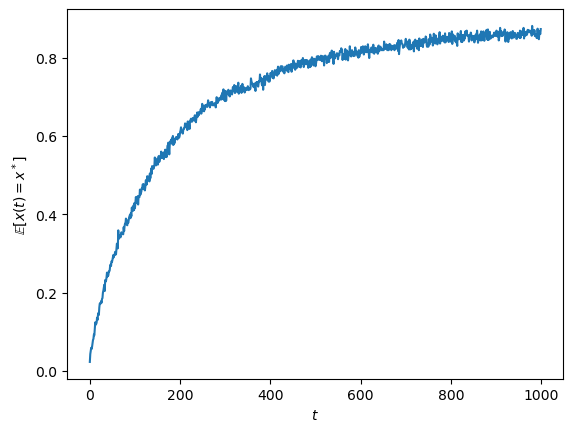

In [19]:
# 正解率の推移
arms_eg, rewards_eg = sim(EpsilonGreedyAgent)
acc = np.mean(arms_eg == Env.opt(), axis = 0)

plt.plot(acc)
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.show()

In [20]:
# 理想の行動を取る全知全能のエージェント
class OracleAgent(object):
    def __init__(self):
        self.arm = Env.opt()

    def get_arm(self):
        return self.arm

    def sample(self, arm, reward):
        pass

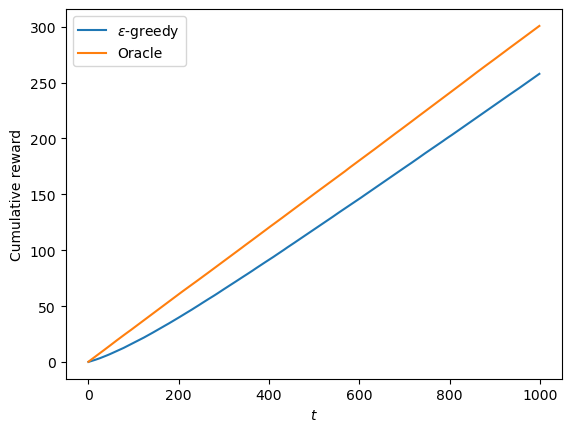

In [22]:
# 累積報酬の履歴
arm_o, rewards_o = sim(OracleAgent)
plt.plot(np.mean(np.cumsum(rewards_eg, axis = 1), axis = 0), label = r'$\varepsilon$-greedy')
plt.plot(np.mean(np.cumsum(rewards_o, axis = 1), axis = 0), label = r'Oracle')
plt.xlabel(r'$t$')
plt.ylabel(r'Cumulative reward')
plt.legend()
plt.show()

In [23]:
# 焼きなましε-greedy
class AnnealingEpsilonGreedyAgent(object):
    def __init__(self, epsilon = 1.0):
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def get_arm(self):
        if np.random.random() < self.epsilon:
            arm = np.random.randint(n_arms)
        else:
            arm = np.argmax(self.values)
        self.epsilon *= 0.99 # 冷却
        return arm

    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = ((self.counts[arm] - 1) * self.values[arm] + reward) / self.counts[arm]

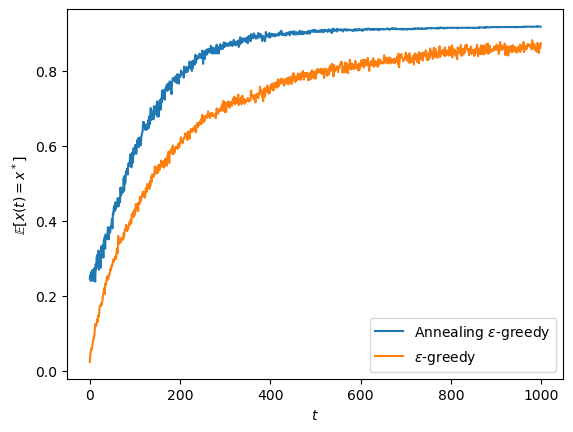

In [25]:
# 正解率の推移
arms_aeg, rewards_aeg = sim(AnnealingEpsilonGreedyAgent)

plt.plot(np.mean(arms_aeg == Env.opt(), axis = 0), label = r'Annealing $\varepsilon$-greedy')
plt.plot(np.mean(arms_eg == Env.opt(), axis = 0), label = r'$\varepsilon$-greedy')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

In [26]:
# ソフトマックスアルゴリズム
# 報酬の標本平均に応じて探索の確率をコントロール
class SoftmaxAgent(object):
    def __init__(self, tau = .05):
        self.tau = tau # 報酬のスケール
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    # 各解を選ぶ確率を算出
    def softmax_p(self):
        logit = self.values / self.tau
        logit = logit - np.max(logit)
        p = np.exp(logit) / sum(np.exp(logit))
        return p

    def get_arm(self):
        arm = np.random.choice(n_arms, p = self.softmax_p())
        return arm

    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = ((self.counts[arm] - 1) * self.values[arm] + reward) / self.counts[arm]

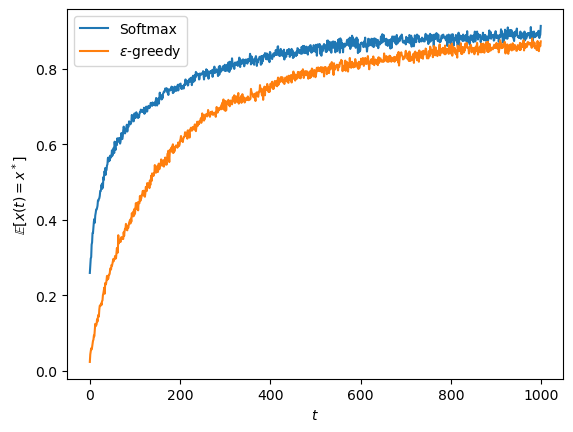

In [35]:
# 正解率の推移
arms_sm, rewards_sm = sim(SoftmaxAgent)

plt.plot(np.mean(arms_sm == Env.opt(), axis = 0), label = r'Softmax')
plt.plot(np.mean(arms_eg == Env.opt(), axis = 0), label = r'$\varepsilon$-greedy')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

In [36]:
# 焼きなましソフトマックスアルゴリズム
class AnnealingSoftmaxAgent(object):
    def __init__(self, tau = 1000.):
        self.tau = tau # 報酬のスケール
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    # 各解を選ぶ確率を算出
    def softmax_p(self):
        logit = self.values / self.tau
        logit = logit - np.max(logit)
        p = np.exp(logit) / sum(np.exp(logit))
        return p

    def get_arm(self):
        arm = np.random.choice(n_arms, p = self.softmax_p())
        self.tau *= 0.9 # 冷却
        return arm

    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = ((self.counts[arm] - 1) * self.values[arm] + reward) / self.counts[arm]

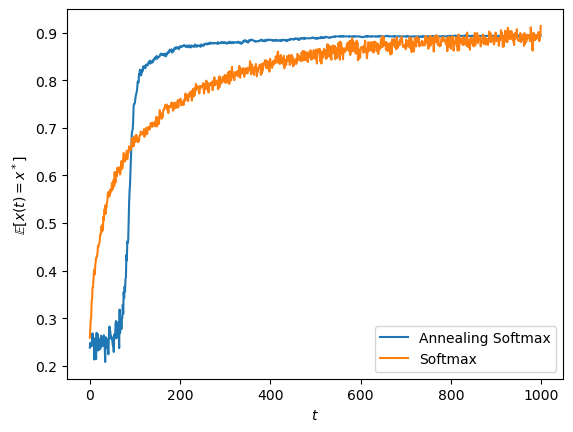

In [37]:
# 正解率の推移
arms_asm, rewards_asm = sim(AnnealingSoftmaxAgent)

plt.plot(np.mean(arms_asm == Env.opt(), axis = 0), label = r'Annealing Softmax')
plt.plot(np.mean(arms_sm == Env.opt(), axis = 0), label = r'Softmax')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

In [40]:
# トンプソンサンプリング
class BernoulliTSAgent(object):
    def __init__(self):
        self.counts = [0 for _ in range(n_arms)]
        self.wins = [0 for _ in range(n_arms)] # 各選択肢の累積報酬

    def get_arm(self):
        beta = lambda N, a: np.random.beta(a + 1, N - a + 1) # 事後分布を計算して乱数を生成
        result = [beta(self.counts[i], self.wins[i]) for i in range(n_arms)]
        arm = result.index(max(result)) # 生成した乱数の内、最大となる値を生成した選択肢を返却
        return arm

    def sample(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        self.wins[arm] = self.wins[arm] + reward

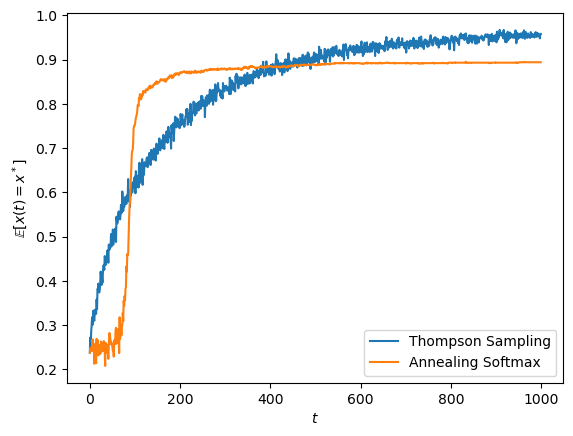

In [41]:
# 正解率の推移
arms_ts, rewards_ts = sim(BernoulliTSAgent)

plt.plot(np.mean(arms_ts == Env.opt(), axis = 0), label = r'Thompson Sampling')
plt.plot(np.mean(arms_asm == Env.opt(), axis = 0), label = r'Annealing Softmax')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

In [42]:
# UCB
# 意思決定に乱数を使わないアルゴリズム
# 報酬の信頼区間の上限が最大となる解を選択する
class UCBAgent(object):
    def __init__(self):
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0 for _ in range(n_arms)]

    def calc_ucb(self, arm):
        ucb = self.values[arm]
        ucb += np.sqrt(np.log(sum(self.counts)) / (2 * self.counts[arm]))
        return ucb

    def get_arm(self):
        if 0 in self.counts:
            # 1回も選択したことのない解があれば、まずそれを選択
            arm = self.counts.index(0)
        else:
            # UCB値を計算して最大となる解を選択
            ucb = [self.calc_ucb(arm) for arm in range(n_arms)]
            arm = ucb.index(max(ucb))
        return arm

    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = ((self.counts[arm] - 1) * self.values[arm] + reward) / self.counts[arm]

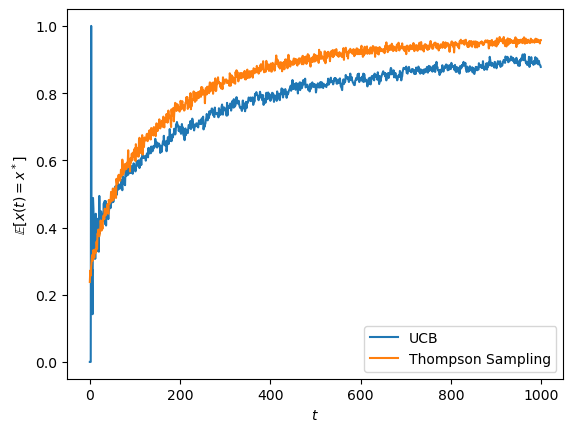

In [44]:
# 正解率の推移
arms_ucb, rewards_ucb = sim(UCBAgent)

plt.plot(np.mean(arms_ucb == Env.opt(), axis = 0), label = r'UCB')
plt.plot(np.mean(arms_ts == Env.opt(), axis = 0), label = r'Thompson Sampling')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()